In [2]:
#import python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
#import python packages for working with .cool, .bigwig and .gtf files
import cooler
import bioframe
import cooltools
import pyBigWig
from gtfparse import read_gtf

In [5]:
# import HiC map in .cool or .mcool 
# note: if you are importing .mcool file, you should specify the resolution
clr = cooler.Cooler('inputs/GSE130275_mESC_WT_combined_2.6B_chr1_3200.cool')
resolution = clr.binsize
print(resolution)

3200


In [6]:
# computing the expected values for each diagonal in cis
view_df=pd.DataFrame({'chrom':clr.chromnames,
                      'start':0,
                      'end':clr.chromsizes.values,
                      'name':clr.chromnames})
expected = cooltools.expected_cis(clr, view_df=view_df, nproc=2, chunksize=1_000_000)
display(expected)

,region1,region2,dist,n_valid,count.sum,balanced.sum,count.avg,balanced.avg,balanced.avg.smoothed,balanced.avg.smoothed.agg
0,chr1,chr1,0,59366,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,chr1,1,58806,NaN,NaN,NaN,NaN,3.488489e-04,3.488489e-04
2,chr1,chr1,2,58741,8789487.0,1924.086881,149.631212,0.032755,2.977595e-02,2.977595e-02
3,chr1,chr1,3,58726,4892228.0,1065.963463,83.305997,0.018151,1.797350e-02,1.797350e-02
4,chr1,chr1,4,58723,3391091.0,738.562921,57.747237,0.012577,1.234306e-02,1.234306e-02
...,...,...,...,...,...,...,...,...,...,...
61080,chr1,chr1,61080,0,0.0,0.000000,NaN,NaN,3.737855e-07,3.737855e-07
61081,chr1,chr1,61081,0,0.0,0.000000,NaN,NaN,3.737819e-07,3.737819e-07
61082,chr1,chr1,61082,0,0.0,0.000000,NaN,NaN,3.737782e-07,3.737782e-07
61083,chr1,chr1,61083,0,0.0,0.000000,NaN,NaN,3.737746e-07,3.737746e-07


In [13]:
# import .gft file to extract Gene/transcript information
df_gene0 = read_gtf("inputs/mm10.ensGene_chr1.gtf")
df_gene0 = df_gene0[df_gene0['feature']=="transcript"]
df_gene0 = df_gene0[['seqname','start','end','strand','gene_id']]
df_gene0['length'] = df_gene0['end']-df_gene0['start']
df_gene0 = df_gene0.sort_values('length', ascending=False).drop_duplicates('gene_id')
df_gene0 = df_gene0.rename(columns = {'seqname': 'chrom'}, inplace = False)
df_gene0 = df_gene0.sort_values(['chrom','start'])
display(df_gene0)

/Users/hsalari/opt/miniconda3/lib/python3.7/site-packages/gtfparse/read_gtf.py:154: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  features=features)
/Users/hsalari/opt/miniconda3/lib/python3.7/site-packages/gtfparse/read_gtf.py:154: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  features=features)
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_name', 'exon_number', 'exon_id']


,chrom,start,end,strand,gene_id,length
0,chr1,3073253,3074322,+,ENSMUSG00000102693,1069
2,chr1,3102016,3102125,+,ENSMUSG00000064842,109
10,chr1,3214482,3671498,-,ENSMUSG00000051951,457016
21,chr1,3252757,3253236,+,ENSMUSG00000102851,479
23,chr1,3365731,3368549,-,ENSMUSG00000103377,2818
...,...,...,...,...,...,...
109529,chr1,195220051,195222766,-,ENSMUSG00000102236,2715
109531,chr1,195228278,195228398,+,ENSMUSG00000093823,120
109533,chr1,195240910,195241007,-,ENSMUSG00000099208,97
109535,chr1,195259299,195259848,-,ENSMUSG00000104297,549


In [14]:
# select a subset of genes based on size, chromosome, ...
# Note: the minimum size of the gene is better to be 10 times higher than HiC resolution
lmin = 10*resolution
lmax = 20*resolution
df_gene = df_gene0[(df_gene0['length']<=lmax)&(df_gene0['length']>=lmin)]
df_gene = df_gene.reset_index(drop=True)
display(df_gene)

,chrom,start,end,strand,gene_id,length
0,chr1,3466587,3513553,+,ENSMUSG00000089699,46966
1,chr1,4807788,4848410,+,ENSMUSG00000025903,40622
2,chr1,4857814,4897905,+,ENSMUSG00000033813,40091
3,chr1,6214645,6276648,+,ENSMUSG00000025907,62003
4,chr1,6359218,6394731,+,ENSMUSG00000087247,35513
...,...,...,...,...,...,...
276,chr1,193221689,193264075,-,ENSMUSG00000016194,42386
277,chr1,194976385,195027428,+,ENSMUSG00000096929,51043
278,chr1,195041238,195092249,-,ENSMUSG00000016493,51011
279,chr1,195097382,195131344,-,ENSMUSG00000016481,33962


In [15]:
# compute intra-gene contact (IC) score, using cooltools.pileup module
flank = (max(df_gene.length))//2
stack = cooltools.pileup(clr, df_gene, view_df=view_df, expected_df=expected, flank=flank)
l = len(df_gene)
fm = flank//resolution
for i in range (l):
    lm = ((df_gene.length[i])//2)//resolution
    b = stack[fm-lm:fm+lm+1,fm-lm:fm+lm+1,i]
    a = b[np.triu_indices(2*lm+1, k = 2)]
    df_gene.loc[i,'IC_score'] = np.nanmean(a)
display(df_gene)

,chrom,start,end,strand,gene_id,length,IC_score
0,chr1,3466587,3513553,+,ENSMUSG00000089699,46966,1.100192
1,chr1,4807788,4848410,+,ENSMUSG00000025903,40622,1.295894
2,chr1,4857814,4897905,+,ENSMUSG00000033813,40091,1.320650
3,chr1,6214645,6276648,+,ENSMUSG00000025907,62003,1.324226
4,chr1,6359218,6394731,+,ENSMUSG00000087247,35513,0.974948
...,...,...,...,...,...,...,...
276,chr1,193221689,193264075,-,ENSMUSG00000016194,42386,0.935091
277,chr1,194976385,195027428,+,ENSMUSG00000096929,51043,1.156510
278,chr1,195041238,195092249,-,ENSMUSG00000016493,51011,0.734466
279,chr1,195097382,195131344,-,ENSMUSG00000016481,33962,1.303364


In [17]:
# compute Intra-gene RNA Pol II (IR) score from PolII ChIP-seq data in BigWig format
pol2 = pyBigWig.open("inputs/GSM4173524_DMSO-N20-input_rep1_chr1.bw")
for i in range(l):
    ch = df_gene.chrom[i]
    start = df_gene.start[i]
    end = df_gene.end[i]
    df_gene.loc[i,'IR_score'] = np.mean(pol2.values(ch,start,end))
display(df_gene)
df_gene.to_csv('outputs/gene_data.txt', sep ='\t', encoding='utf-8',index=False)

,chrom,start,end,strand,gene_id,length,IC_score,IR_score
0,chr1,3466587,3513553,+,ENSMUSG00000089699,46966,1.100192,0.259446
1,chr1,4807788,4848410,+,ENSMUSG00000025903,40622,1.295894,3.726281
2,chr1,4857814,4897905,+,ENSMUSG00000033813,40091,1.320650,4.367942
3,chr1,6214645,6276648,+,ENSMUSG00000025907,62003,1.324226,1.216582
4,chr1,6359218,6394731,+,ENSMUSG00000087247,35513,0.974948,0.303108
...,...,...,...,...,...,...,...,...
276,chr1,193221689,193264075,-,ENSMUSG00000016194,42386,0.935091,0.397804
277,chr1,194976385,195027428,+,ENSMUSG00000096929,51043,1.156510,0.495063
278,chr1,195041238,195092249,-,ENSMUSG00000016493,51011,0.734466,0.389001
279,chr1,195097382,195131344,-,ENSMUSG00000016481,33962,1.303364,1.248526


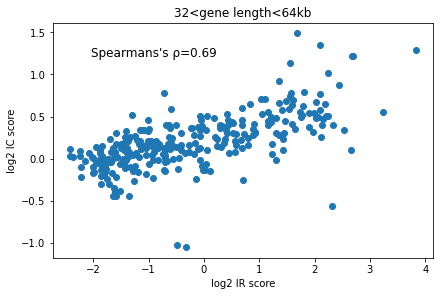

In [19]:
# plotting IC score against IR score and computing the Spearman's correlation
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4),constrained_layout = True)
df_gene.loc[:,'log2_IC_score'] = np.log2(df_gene['IC_score'].replace(0,np.nan))
df_gene.loc[:,'log2_IR_score'] = np.log2(df_gene['IR_score'].replace(0,np.nan))
ax.scatter(df_gene['log2_IR_score'],df_gene['log2_IC_score'])
ax.set_xlabel('log2 IR score')
ax.set_ylabel('log2 IC score')
ax.set_title(str(lmin//1000)+'<gene length<'+str(lmax//1000)+'kb')
c = "{:.2f}".format(df_gene['log2_IR_score'].corr(df_gene['log2_IC_score'],method='spearman'))
plt.text(0.1,0.9, "Spearmans's \u03C1="+str(c), fontsize=12,
        ha='left',
        va='top',
        transform=ax.transAxes)

fig.savefig("outputs/IC_IR_scatterplot.png")